In [1]:
# If the processing environment is Google Colab with files inside Google Drive,
# inform the path where the notebook file is located inside this drive

path_notebook_gdrive = 'notebooks/technical_tests/justforyou_test_ds_job_20220807'

In [2]:
# Mounting Google Drive if using Google Colab

if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive/')

In [3]:
# Change the current working directory to the folder containing this notebook if using Google Colab

if 'google.colab' in str(get_ipython()):
    %cd /content/drive/My\ Drive/$path_notebook_gdrive/

In [4]:
# Installation of additional libraries if using Google Colab

# if 'google.colab' in str(get_ipython()):
#     !pip install <library>

# Correlação entre Compradores e Leads / *Correlation Between Buyers and Leads*

# Desafio de Ciência de Dados / *Data Science Challenge*

# Entrega / *Delivery*: Notebook

# Desenvolvedor / *Developer*: Solano Jacon

In [5]:
import psycopg2 # if necessary, install psycopg2-binary library, NOT psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pickle
import warnings
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from pycaret.classification import *
from sklearn.model_selection import train_test_split, cross_validate
# from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
# from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.ensemble import GradientBoostingClassifier
# from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve

warnings.filterwarnings('ignore')

## Leitura dos dados e normalização / *Data reading and normalization*

### Conexão com a base de dados e leitura dos dados / *Database connection and data reading*

In [6]:
# conn = psycopg2.connect(database='database',
#                         host='host',
#                         user='user',
#                         password='password',
#                         port='port')

In [7]:
# sql = '''SELECT f.*, oi.id_pedido, oi.id
#          FROM forms AS f
#          LEFT OUTER JOIN order_items AS oi ON f.id_form=oi.id_form'''
# data = pd.read_sql_query(sql, con=conn)

In [8]:
data = pd.read_csv('data/data.csv', index_col=0, encoding='iso-8859-1')

In [9]:
data.iloc[:, :9]

,id_form,id_cliente,data,sistema_operacional,navegador,localizacao,locale,cidade,estado
0,c7d453c9c01223a42968d9fe136047,d2620a3e6f00a6dc6e88,2022-01-03 15:42:22,iOS,Safari,"São Paulo, Sao Paulo",BR,SÃO PAULO,SAO PAULO
1,c7d453c9c01223a42968d9fe136047,d2620a3e6f00a6dc6e88,2022-01-03 15:42:22,iOS,Safari,"São Paulo, Sao Paulo",BR,SÃO PAULO,SAO PAULO
2,c7d453c9c01223a42968d9fe136047,d2620a3e6f00a6dc6e88,2022-01-03 15:42:22,iOS,Safari,"São Paulo, Sao Paulo",BR,SÃO PAULO,SAO PAULO
3,c7d453c9c01223a42968d9fe136047,d2620a3e6f00a6dc6e88,2022-01-03 15:42:22,iOS,Safari,"São Paulo, Sao Paulo",BR,SÃO PAULO,SAO PAULO
4,72830da153824af486be15cd48b3f3,9a48802d8290d19471f3,2022-01-04 08:39:53,Windows,Chrome,"Ribeirão Preto, Sao Paulo",BR,RIBEIRÃO PRETO,SAO PAULO
...,...,...,...,...,...,...,...,...,...
585467,b52c38b852d68ec4b5c8f4fcdf2604,3e0f5c6131151b075a34,2022-02-26 21:28:12,iOS,NaN,"Santa Barbara, Bahia",BR,SANTA BARBARA,BAHIA
585468,df3bb506075aa2e212d9a0bf90975d,0266fbc12fe7e7487605,2022-03-03 18:01:43,Windows,Chrome,"Sao Pedro, Sao Paulo",BR,SAO PEDRO,SAO PAULO
585469,c172d08a3a36b903cd49f6af8da9c3,b6c0b82cc271fd1203fc,2022-01-27 18:09:34,Windows,Chrome,"Itatiba, Sao Paulo",BR,ITATIBA,SAO PAULO
585470,369f40f668082066838beec2861a40,47e6af54dc5898b49ec3,2022-01-27 18:52:16,Android,Chrome,"Arapoti, Parana",BR,ARAPOTI,PARANA


In [10]:
data.iloc[:, 9:18]

,qtde_lavagem_semana,utm_source,tipo_cabelo,comprimento,tipo_fios,procedimentos,tempo_procedimento,dieta,atividade_fisica
0,4,NaN,Tipo 2,Raíz exposta,Pontas duplas,Nenhum,Há 2 semanas,Celíaca,Frequente
1,4,NaN,Tipo 2,Raíz exposta,Pontas duplas,Nenhum,Há 2 semanas,Celíaca,Frequente
2,4,NaN,Tipo 2,Raíz exposta,Pontas duplas,Nenhum,Há 2 semanas,Celíaca,Frequente
3,4,NaN,Tipo 2,Raíz exposta,Pontas duplas,Nenhum,Há 2 semanas,Celíaca,Frequente
4,7,NaN,Tipo 4,Muito curto,Perfeitos,Todos acima,Há mais de 1 mês,Nenhuma restrição,Nunca
...,...,...,...,...,...,...,...,...,...
585467,4,linktree,Tipo 1,Muito curto,Rebeldes,Nenhum,Há 1 semana,Nenhuma restrição,Frequente
585468,1,NaN,Tipo 1,Raíz exposta,Pontas duplas,Tintura,Há 1 mês,Celíaca,Raramente
585469,7,NaN,Tipo 1,Muito curto,Perfeitos,Nenhum,Há mais de 1 mês,Nenhuma restrição,Sempre
585470,4,NaN,Tipo 1,Raíz exposta,Pontas duplas,Todos acima,Há mais de 1 mês,Nenhuma restrição,Sempre


In [11]:
data.iloc[:, 18:]

,frequencia_estresse,caracteristica,faixa_etaria,efeitos_desejados,fragancia,id_pedido,id
0,Nunca,Característica 1,25 a 34,Efeito 7,Rosas,5d2301cb6bf9d7c,426190.0
1,Nunca,Característica 1,25 a 34,Efeito 7,Rosas,5d2301cb6bf9d7c,426189.0
2,Nunca,Característica 1,25 a 34,Efeito 7,Rosas,5d2301cb6bf9d7c,426188.0
3,Nunca,Característica 1,25 a 34,Efeito 7,Rosas,5d2301cb6bf9d7c,426187.0
4,Nunca,Característica 6,55 a 64,Efeito 1,Eucalipto,NaN,NaN
...,...,...,...,...,...,...,...
585467,Uma vez por mês,Característica 7,18 a 24,Efeito 7,Rosas,NaN,NaN
585468,Regularmente,Característica 9,65+,"Efeito 7, Efeito 1, Efeito 5",Flores do campo,NaN,NaN
585469,Nunca,Característica 6,55 a 64,Efeito 1,Eucalipto,NaN,NaN
585470,Nunca,Característica 8,18 a 24,"Efeito 7, Efeito 1, Efeito 5, Efeito 8",Eucalipto,NaN,NaN


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 585472 entries, 0 to 585471
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id_form              585472 non-null  object 
 1   id_cliente           585472 non-null  object 
 2   data                 585472 non-null  object 
 3   sistema_operacional  585472 non-null  object 
 4   navegador            453493 non-null  object 
 5   localizacao          585472 non-null  object 
 6   locale               585472 non-null  object 
 7   cidade               565977 non-null  object 
 8   estado               585240 non-null  object 
 9   qtde_lavagem_semana  585472 non-null  int64  
 10  utm_source           509386 non-null  object 
 11  tipo_cabelo          585472 non-null  object 
 12  comprimento          585472 non-null  object 
 13  tipo_fios            585472 non-null  object 
 14  procedimentos        585472 non-null  object 
 15  tempo_procediment

In [13]:
data.isna().sum()

id_form                     0
id_cliente                  0
data                        0
sistema_operacional         0
navegador              131979
localizacao                 0
locale                      0
cidade                  19495
estado                    232
qtde_lavagem_semana         0
utm_source              76086
tipo_cabelo                 0
comprimento                 0
tipo_fios                   0
procedimentos               0
tempo_procedimento          0
dieta                       0
atividade_fisica            0
frequencia_estresse         0
caracteristica              0
faixa_etaria                0
efeitos_desejados        1241
fragancia                   0
id_pedido              373809
id                     373809
dtype: int64

In [14]:
data = data.fillna(value=np.nan)

In [15]:
caracteres_especiais = ['\u014c', '\u014d', '\u0160', '\u0161']
caracteres_substitutos = ['O', 'o', 'S', 's']

for caractere_especial, caractere_substituto in zip(caracteres_especiais, caracteres_substitutos):
    data.loc[data['localizacao'].notna(), 'localizacao'] = data.loc[data['localizacao'].notna(), 'localizacao'].apply(lambda x: x.replace(caractere_especial, caractere_substituto))
    data.loc[data['cidade'].notna(), 'cidade'] = data.loc[data['cidade'].notna(), 'cidade'].apply(lambda x: x.replace(caractere_especial, caractere_substituto))
    data.loc[data['estado'].notna(), 'estado'] = data.loc[data['estado'].notna(), 'estado'].apply(lambda x: x.replace(caractere_especial, caractere_substituto))

In [16]:
# data.to_csv('data/data.csv', encoding='iso-8859-1')

### Análise dos Dados / *Data Analysis*

In [17]:
data['data'].min()

'2022-01-01 00:13:01'

In [18]:
data['data'].max()

'2022-06-30 23:57:47'

In [19]:
data['sistema_operacional'].value_counts(normalize=True, dropna=False)

Android      0.597637
iOS          0.330841
Windows      0.063573
Mac OS       0.005380
Linux        0.002193
 ChromeOS    0.000376
Name: sistema_operacional, dtype: float64

In [20]:
data['navegador'].value_counts(normalize=True, dropna=False)

Chrome            0.658274
NaN               0.225423
Safari            0.101281
ChromeiOS         0.006603
ChromiumEdge      0.004099
Firefox           0.002856
Opera             0.001443
MSEdge            0.000012
Yandex.Browser    0.000009
Name: navegador, dtype: float64

In [21]:
data['localizacao'].value_counts(normalize=True, dropna=False)

São Paulo, Sao Paulo              0.128623
Rio de Janeiro, Rio de Janeiro    0.045292
Belo Horizonte, Minas Gerais      0.025294
null, null                        0.023654
Brasília, Federal District        0.023260
                                    ...   
Lady Lake, Florida                0.000002
Aratuba, Ceara                    0.000002
Fanhoes, Lisbon                   0.000002
Elk River, Minnesota              0.000002
Cebu City, Central Visayas        0.000002
Name: localizacao, Length: 5679, dtype: float64

In [22]:
data['locale'].value_counts(normalize=True, dropna=False)

BR    1.0
Name: locale, dtype: float64

In [23]:
data['cidade'].value_counts(normalize=True, dropna=False)

SÃO PAULO         0.128623
RIO DE JANEIRO    0.045292
NaN               0.033298
BELO HORIZONTE    0.025318
BRASÍLIA          0.023260
                    ...   
BRIDGWATER        0.000002
ALTO BOA VISTA    0.000002
MIDDLEBORO        0.000002
TURKU             0.000002
CEBU CITY         0.000002
Name: cidade, Length: 5315, dtype: float64

In [24]:
data['estado'].value_counts(normalize=True, dropna=False)

 SAO PAULO                             0.324434
 MINAS GERAIS                          0.089432
 RIO DE JANEIRO                        0.084059
 PARANA                                0.062290
 RIO GRANDE DO SUL                     0.050686
 SANTA CATARINA                        0.049866
 BAHIA                                 0.040340
 CEARA                                 0.034642
 PERNAMBUCO                            0.033511
 GOIAS                                 0.028244
 FEDERAL DISTRICT                      0.023982
 NULL                                  0.023678
 MATO GROSSO                           0.016745
 PARA                                  0.015360
 ESPIRITO SANTO                        0.014899
 MATO GROSSO DO SUL                    0.013072
 PARAÍBA                               0.012455
 MARANHAO                              0.012422
 RIO GRANDE DO NORTE                   0.012221
 ALAGOAS                               0.012098
 AMAZONAS                              0

In [25]:
data['qtde_lavagem_semana'].value_counts(normalize=True, dropna=False)

4    0.321218
1    0.267693
2    0.160269
6    0.082084
5    0.080099
3    0.053704
7    0.034932
Name: qtde_lavagem_semana, dtype: float64

In [26]:
data['utm_source'].value_counts(normalize=True, dropna=False)

influencer         0.316890
facebook           0.206488
NaN                0.129957
google             0.086556
sf_wpp_camp        0.066584
linktree           0.053991
instagram          0.046786
sf_email_camp      0.036611
sf_wpp_flux        0.025072
rakuten            0.008084
IGShopping         0.007879
email_sf           0.003964
blog               0.003013
tiktok             0.001933
microinfluencer    0.001732
adwords            0.001578
site               0.001370
sf_email_flux      0.000905
meliuz             0.000167
incicacao          0.000130
salesforce         0.000114
whatsapp           0.000050
telegram           0.000032
sendinblue         0.000032
sf_sms_camp        0.000017
cpc                0.000012
sf_wpp_flu         0.000012
teste_source       0.000007
sms                0.000007
facebook           0.000005
uaubox             0.000003
popup              0.000003
sf_camp_email      0.000003
email              0.000002
Facebook ads       0.000002
santander          0

In [27]:
data['tipo_cabelo'].value_counts(normalize=True, dropna=False)

Tipo 1    0.421457
Tipo 2    0.364034
Tipo 4    0.173897
Tipo 3    0.040612
Name: tipo_cabelo, dtype: float64

In [28]:
data['comprimento'].value_counts(normalize=True, dropna=False)

Muito curto     0.472550
Raíz exposta    0.356700
Longo           0.123586
Extra longo     0.047164
Name: comprimento, dtype: float64

In [29]:
data['tipo_fios'].value_counts(normalize=True, dropna=False)

Secos            0.570929
Pontas duplas    0.169395
Rebeldes         0.167234
Perfeitos        0.092442
Name: tipo_fios, dtype: float64

In [30]:
data['procedimentos'].value_counts(normalize=True, dropna=False)

Corte agressivo                                       0.182757
Todos acima                                           0.153710
Tintura                                               0.086262
Exposição ao sol                                      0.081025
Tintura, Corte agressivo                              0.076801
Nenhum                                                0.062273
Corte agressivo, Exposição ao sol                     0.033127
Corte agressivo, Nenhum                               0.032500
Tintura, Corte agressivo, Exposição ao sol            0.029539
Corte agressivo, Tintura                              0.026471
Nenhum, Corte agressivo                               0.022440
Tintura, Corte agressivo, Nenhum                      0.017463
Exposição ao sol, Corte agressivo                     0.017114
Tintura, Corte agressivo, Nenhum, Exposição ao sol    0.015611
Nenhum, Exposição ao sol                              0.015601
Tintura, Exposição ao sol                             0

In [31]:
data['tempo_procedimento'].value_counts(normalize=True, dropna=False)

Há 2 semanas               0.331857
Há 1 semana                0.272761
Há mais de 1 mês           0.185780
Há 1 mês                   0.116562
Não houve procedimentos    0.093039
Name: tempo_procedimento, dtype: float64

In [32]:
data['dieta'].value_counts(normalize=True, dropna=False)

Celíaca                  0.719338
Nenhuma restrição        0.218648
Intolerante a lactose    0.044089
Leve                     0.017926
Name: dieta, dtype: float64

In [33]:
data['atividade_fisica'].value_counts(normalize=True, dropna=False)

Raramente    0.524749
Frequente    0.283120
Sempre       0.094459
N/C          0.084467
Nunca        0.013205
Name: atividade_fisica, dtype: float64

In [34]:
data['frequencia_estresse'].value_counts(normalize=True, dropna=False)

Uma vez por mês    0.524146
Nunca              0.410898
Regularmente       0.060179
Quase sempre       0.004777
Name: frequencia_estresse, dtype: float64

In [35]:
data['caracteristica'].value_counts(normalize=True, dropna=False)

Característica 3                                                                                               0.268011
Característica 7                                                                                               0.103595
Característica 1                                                                                               0.093536
Característica 3, Característica 8                                                                             0.085174
Característica 2                                                                                               0.040010
                                                                                                                 ...   
Característica 3, Característica 1, Característica 9, Característica 8, Característica 4, Característica 10    0.000002
Característica 8, Característica 3, Característica 10, Característica 1, Característica 9, Característica 4    0.000002
Característica 6, Característica 1, Cara

In [36]:
data['faixa_etaria'].value_counts(normalize=True, dropna=False)

25 a 34    0.368976
18 a 24    0.269557
35 a 44    0.190400
45 a 54    0.068461
11 a 17    0.067578
55 a 64    0.021719
2 a 10     0.007476
65+        0.005833
Name: faixa_etaria, dtype: float64

In [37]:
data['efeitos_desejados'].value_counts(normalize=True, dropna=False)

Efeito 6, Efeito 7, Efeito 4, Efeito 3               0.014785
Efeito 6, Efeito 7, Efeito 8, Efeito 4, Efeito 3     0.014747
Efeito 6, Efeito 7, Efeito 8, Efeito 4               0.012257
Efeito 7                                             0.010769
Efeito 6, Efeito 2, Efeito 4, Efeito 3               0.009478
                                                       ...   
Efeito 3, Efeito 8, Efeito 1, Efeito 4, Efeito 7     0.000002
Efeito 1, Efeito 8, Efeito 3, Efeito 4, Efeito 5     0.000002
Efeito 4, Efeito 10, Efeito 2, Efeito 7, Efeito 1    0.000002
Efeito 10, Efeito 3, Efeito 2, Efeito 4, Efeito 1    0.000002
Efeito 8, Efeito 4, Efeito 10, Efeito 2, Efeito 7    0.000002
Name: efeitos_desejados, Length: 11836, dtype: float64

In [38]:
data['fragancia'].value_counts(normalize=True, dropna=False)

Rosas              0.522672
Eucalipto          0.380327
Flores do campo    0.097000
Name: fragancia, dtype: float64

### Preparação e Análise dos Dados Alvo / *Target Data Preparation and Analysis*

In [39]:
data['pedido'] = 0
data.loc[data['id_pedido'].notna(), 'pedido'] = 1

In [40]:
data['pedido'].value_counts(normalize=True, dropna=False)

0    0.638475
1    0.361525
Name: pedido, dtype: float64

### Definição dos Próximos Passos / *Definition of Next Steps*

Criação de features:
- tempo_procedimento: transformação do conteúdo de categorias ordinais de texto para categorias ordinais numéricas
- faixa_etaria: transformação do conteúdo de categorias ordinais de texto para categorias ordinais numéricas
- procedimentos: separação do conteúdo de categorias em colunas binárias para cada categoria
- caracteristica: separação do conteúdo de categorias em colunas binárias para cada categoria
- efeitos_desejados: separação do conteúdo de categorias em colunas binárias para cada categoria

*Feature creation*:
- *tempo_procedimento: transforming content from ordinal text categories to numeric ordinal categories*
- *faixa_etaria: transforming content from ordinal text categories to numeric ordinal categories*
- *procedimentos: separation of categories content into binary columns for each category*
- *caracteristica: separation of categories content into binary columns for each category*
- *efeitos_desejados: separation of categories content into binary columns for each category*

Encoding:
- sistema_operacional
- estado
- utm_source
- tipo_cabelo
- comprimento
- tipo_fios
- dieta
- atividade_fisica
- frequencia_estresse

Scaling:
- qtde_lavagem_semana

### Criação de Features / *Feature Creation*

**tempo_procedimento**

In [41]:
data['tempo_procedimento'].value_counts(normalize=True, dropna=False)

Há 2 semanas               0.331857
Há 1 semana                0.272761
Há mais de 1 mês           0.185780
Há 1 mês                   0.116562
Não houve procedimentos    0.093039
Name: tempo_procedimento, dtype: float64

In [42]:
data.loc[data['tempo_procedimento']=='Não houve procedimentos', 'tempo_procedimento_quantificado'] = 0
data.loc[data['tempo_procedimento']=='Há 1 semana', 'tempo_procedimento_quantificado'] = 1
data.loc[data['tempo_procedimento']=='Há 2 semanas', 'tempo_procedimento_quantificado'] = 2
data.loc[data['tempo_procedimento']=='Há 1 mês', 'tempo_procedimento_quantificado'] = 3
data.loc[data['tempo_procedimento']=='Há mais de 1 mês', 'tempo_procedimento_quantificado'] = 4

In [43]:
data['tempo_procedimento_quantificado'].value_counts(normalize=True, dropna=False)

2.0    0.331857
1.0    0.272761
4.0    0.185780
3.0    0.116562
0.0    0.093039
Name: tempo_procedimento_quantificado, dtype: float64

**faixa_etaria**

In [44]:
data['faixa_etaria'].value_counts(normalize=True, dropna=False)

25 a 34    0.368976
18 a 24    0.269557
35 a 44    0.190400
45 a 54    0.068461
11 a 17    0.067578
55 a 64    0.021719
2 a 10     0.007476
65+        0.005833
Name: faixa_etaria, dtype: float64

In [45]:
data.loc[data['faixa_etaria']=='2 a 10', 'faixa_etaria_quantificado'] = 1
data.loc[data['faixa_etaria']=='11 a 17', 'faixa_etaria_quantificado'] = 2
data.loc[data['faixa_etaria']=='18 a 24', 'faixa_etaria_quantificado'] = 3
data.loc[data['faixa_etaria']=='25 a 34', 'faixa_etaria_quantificado'] = 4
data.loc[data['faixa_etaria']=='35 a 44', 'faixa_etaria_quantificado'] = 5
data.loc[data['faixa_etaria']=='45 a 54', 'faixa_etaria_quantificado'] = 6
data.loc[data['faixa_etaria']=='55 a 64', 'faixa_etaria_quantificado'] = 7
data.loc[data['faixa_etaria']=='65+', 'faixa_etaria_quantificado'] = 8

In [46]:
data['faixa_etaria_quantificado'].value_counts(normalize=True, dropna=False)

4.0    0.368976
3.0    0.269557
5.0    0.190400
6.0    0.068461
2.0    0.067578
7.0    0.021719
1.0    0.007476
8.0    0.005833
Name: faixa_etaria_quantificado, dtype: float64

**procedimentos**

In [47]:
data['procedimentos'].value_counts(normalize=True, dropna=False)

Corte agressivo                                       0.182757
Todos acima                                           0.153710
Tintura                                               0.086262
Exposição ao sol                                      0.081025
Tintura, Corte agressivo                              0.076801
Nenhum                                                0.062273
Corte agressivo, Exposição ao sol                     0.033127
Corte agressivo, Nenhum                               0.032500
Tintura, Corte agressivo, Exposição ao sol            0.029539
Corte agressivo, Tintura                              0.026471
Nenhum, Corte agressivo                               0.022440
Tintura, Corte agressivo, Nenhum                      0.017463
Exposição ao sol, Corte agressivo                     0.017114
Tintura, Corte agressivo, Nenhum, Exposição ao sol    0.015611
Nenhum, Exposição ao sol                              0.015601
Tintura, Exposição ao sol                             0

In [48]:
procedimentos = ['Corte agressivo', 'Exposição ao sol', 'Nenhum', 'N/C', 'Tintura', 'Todos acima']

for procedimento in procedimentos:
    data['procedimento ' + procedimento] = data['procedimentos'].apply(lambda x: 1 if procedimento in x else 0)

In [49]:
data['procedimentos']

0                            Nenhum
1                            Nenhum
2                            Nenhum
3                            Nenhum
4                       Todos acima
                    ...            
585467                       Nenhum
585468                      Tintura
585469                       Nenhum
585470                  Todos acima
585471    Exposição ao sol, Tintura
Name: procedimentos, Length: 585472, dtype: object

In [50]:
data.iloc[:, -6:]

,procedimento Corte agressivo,procedimento Exposição ao sol,procedimento Nenhum,procedimento N/C,procedimento Tintura,procedimento Todos acima
0,0,0,1,0,0,0
1,0,0,1,0,0,0
2,0,0,1,0,0,0
3,0,0,1,0,0,0
4,0,0,0,0,0,1
...,...,...,...,...,...,...
585467,0,0,1,0,0,0
585468,0,0,0,0,1,0
585469,0,0,1,0,0,0
585470,0,0,0,0,0,1


**caracteristica**

In [51]:
data['caracteristica'].value_counts(normalize=True, dropna=False)

Característica 3                                                                                               0.268011
Característica 7                                                                                               0.103595
Característica 1                                                                                               0.093536
Característica 3, Característica 8                                                                             0.085174
Característica 2                                                                                               0.040010
                                                                                                                 ...   
Característica 3, Característica 1, Característica 9, Característica 8, Característica 4, Característica 10    0.000002
Característica 8, Característica 3, Característica 10, Característica 1, Característica 9, Característica 4    0.000002
Característica 6, Característica 1, Cara

In [52]:
# A coluna caracteristica contém 10 categorias de 1 a 10 no formato "Característica 5"
# The column caracteristica contains 10 categories from 1 to 10 in the "Característica 5" format

for numero_caracteristica in range(1, 11):
    data['caracteristica ' + str(numero_caracteristica)] = data['caracteristica'].apply(lambda x: 1 if ('Característica ' + str(numero_caracteristica)) in x else 0)

In [53]:
data['caracteristica']

0         Característica 1
1         Característica 1
2         Característica 1
3         Característica 1
4         Característica 6
                ...       
585467    Característica 7
585468    Característica 9
585469    Característica 6
585470    Característica 8
585471    Característica 2
Name: caracteristica, Length: 585472, dtype: object

In [54]:
data.iloc[:, -10:]

,caracteristica 1,caracteristica 2,caracteristica 3,caracteristica 4,caracteristica 5,caracteristica 6,caracteristica 7,caracteristica 8,caracteristica 9,caracteristica 10
0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
585467,0,0,0,0,0,0,1,0,0,0
585468,0,0,0,0,0,0,0,0,1,0
585469,0,0,0,0,0,1,0,0,0,0
585470,0,0,0,0,0,0,0,1,0,0


**efeitos_desejados**

In [55]:
data['efeitos_desejados'].value_counts(normalize=True, dropna=False)

Efeito 6, Efeito 7, Efeito 4, Efeito 3               0.014785
Efeito 6, Efeito 7, Efeito 8, Efeito 4, Efeito 3     0.014747
Efeito 6, Efeito 7, Efeito 8, Efeito 4               0.012257
Efeito 7                                             0.010769
Efeito 6, Efeito 2, Efeito 4, Efeito 3               0.009478
                                                       ...   
Efeito 3, Efeito 8, Efeito 1, Efeito 4, Efeito 7     0.000002
Efeito 1, Efeito 8, Efeito 3, Efeito 4, Efeito 5     0.000002
Efeito 4, Efeito 10, Efeito 2, Efeito 7, Efeito 1    0.000002
Efeito 10, Efeito 3, Efeito 2, Efeito 4, Efeito 1    0.000002
Efeito 8, Efeito 4, Efeito 10, Efeito 2, Efeito 7    0.000002
Name: efeitos_desejados, Length: 11836, dtype: float64

In [56]:
# A coluna efeitos_desejados contém 10 categorias de 1 a 10 no formato "Efeito 5"
# The column efeitos_desejados contains 10 categories from 1 to 10 in the "Efeito 5" format

data['efeitos_desejados_modificado'] = data['efeitos_desejados'].fillna(value='Nenhum')

for numero_efeito in range(1, 11):
    data['efeitos_desejados ' + str(numero_efeito)] = data['efeitos_desejados_modificado'].apply(lambda x: 1 if ('Efeito ' + str(numero_efeito)) in x else 0)

In [57]:
data['efeitos_desejados']

0                                       Efeito 7
1                                       Efeito 7
2                                       Efeito 7
3                                       Efeito 7
4                                       Efeito 1
                           ...                  
585467                                  Efeito 7
585468              Efeito 7, Efeito 1, Efeito 5
585469                                  Efeito 1
585470    Efeito 7, Efeito 1, Efeito 5, Efeito 8
585471                                  Efeito 8
Name: efeitos_desejados, Length: 585472, dtype: object

In [58]:
data.iloc[:, -10:]

,efeitos_desejados 1,efeitos_desejados 2,efeitos_desejados 3,efeitos_desejados 4,efeitos_desejados 5,efeitos_desejados 6,efeitos_desejados 7,efeitos_desejados 8,efeitos_desejados 9,efeitos_desejados 10
0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,1,0,0,0
4,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
585467,0,0,0,0,0,0,1,0,0,0
585468,1,0,0,0,1,0,1,0,0,0
585469,1,0,0,0,0,0,0,0,0,0
585470,1,0,0,0,1,0,1,1,0,0


### Encoding

**sistema_operacional**

In [59]:
data['sistema_operacional'].unique()

array(['iOS', 'Windows', 'Android', 'Mac OS', 'Linux', ' ChromeOS'],
      dtype=object)

In [60]:
feature_to_encode = 'sistema_operacional'
ohe = OneHotEncoder(sparse=False)
column_encoded = ohe.fit_transform(data[[feature_to_encode]])
data[feature_to_encode + '_e_' + ohe.categories_[0]] = column_encoded

In [61]:
ohe.categories_

[array([' ChromeOS', 'Android', 'Linux', 'Mac OS', 'Windows', 'iOS'],
       dtype=object)]

In [62]:
data.columns

Index(['id_form', 'id_cliente', 'data', 'sistema_operacional', 'navegador',
       'localizacao', 'locale', 'cidade', 'estado', 'qtde_lavagem_semana',
       'utm_source', 'tipo_cabelo', 'comprimento', 'tipo_fios',
       'procedimentos', 'tempo_procedimento', 'dieta', 'atividade_fisica',
       'frequencia_estresse', 'caracteristica', 'faixa_etaria',
       'efeitos_desejados', 'fragancia', 'id_pedido', 'id', 'pedido',
       'tempo_procedimento_quantificado', 'faixa_etaria_quantificado',
       'procedimento Corte agressivo', 'procedimento Exposição ao sol',
       'procedimento Nenhum', 'procedimento N/C', 'procedimento Tintura',
       'procedimento Todos acima', 'caracteristica 1', 'caracteristica 2',
       'caracteristica 3', 'caracteristica 4', 'caracteristica 5',
       'caracteristica 6', 'caracteristica 7', 'caracteristica 8',
       'caracteristica 9', 'caracteristica 10', 'efeitos_desejados_modificado',
       'efeitos_desejados 1', 'efeitos_desejados 2', 'efeitos_desejado

**estado**

In [63]:
data['estado'].unique()

array([' SAO PAULO', ' ENGLAND', ' SANTA CATARINA', ' ALAGOAS', ' CEARA',
       ' BAHIA', ' PIAUI', ' QUEBEC', ' PARANA', ' AMAZONAS', ' NULL',
       ' RIO DE JANEIRO', ' PERNAMBUCO', ' MATO GROSSO', ' MINAS GERAIS',
       ' TOCANTINS', ' PARA', ' RIO GRANDE DO SUL',
       ' RIO GRANDE DO NORTE', ' GOIAS', ' VIRGINIA', ' FEDERAL DISTRICT',
       ' RONDONIA', ' SERGIPE', ' MARANHAO', ' AMAPA', ' PARAÍBA',
       ' TEXAS', ' ESPIRITO SANTO', " PROVENCE-ALPES-CÔTE D'AZUR",
       ' MATO GROSSO DO SUL', ' RORAIMA', ' DEPARTAMENTO DE CAAGUAZU',
       ' ACRE', ' PORTO', ' DEPARTAMENTO DE MISIONES',
       ' NORTH RHINE-WESTPHALIA', ' NEW YORK', ' CONNECTICUT', ' LEIRIA',
       ' LISBON', ' BRITISH COLUMBIA', ' SANTIAGO METROPOLITAN',
       ' MADRID', ' FLANDERS', ' APULIA', ' AICHI', ' BASQUE COUNTRY',
       ' OHIO', ' DEPARTAMENTO DEL MAGDALENA', ' BRAGA',
       ' DEPARTAMENTO DEL ALTO PARANA', ' GIZA', ' WISCONSIN', ' ÉVORA',
       ' VIANA DO CASTELO', ' CASTELO BRANCO', ' DEPAR

In [64]:
data['estado_modificado'] = data['estado'].fillna(value='SEM PREENCHIMENTO')

In [65]:
feature_to_encode = 'estado_modificado'
ohe = OneHotEncoder(sparse=False)
column_encoded = ohe.fit_transform(data[[feature_to_encode]])
data[feature_to_encode + '_e_' + ohe.categories_[0]] = column_encoded

In [66]:
ohe.categories_[0]

array([' AARGAU', ' ABRUZZO', ' ABU DHABI', ' ACRE', ' AICHI',
       ' AL ASIMAH', ' ALABAMA', ' ALAGOAS', ' ALBERTA', ' AMAPA',
       ' AMAZONAS', ' ANDALUSIA', ' ANTIOQUIA', ' APULIA', ' ARAGON',
       ' ARIZONA', ' ASUNCION', ' ATLÁNTICO', ' ATTICA', ' AUCKLAND',
       ' AUVERGNE-RHONE-ALPES', ' AVEIRO', ' AZORES',
       ' BADEN-WÜRTTEMBERG', ' BAFATA', ' BAHIA', ' BAJA CALIFORNIA',
       ' BALADIYAT AD DAWHAH', ' BALEARIC ISLANDS', ' BARANYA',
       ' BASQUE COUNTRY', ' BAVARIA', ' BEJA', ' BERN', ' BICOL',
       ' BOGOTA D.C.', ' BRAGA', ' BRAGANÇA', ' BRATISLAVA',
       ' BRITISH COLUMBIA', ' BRITTANY', ' BRUSSELS CAPITAL', ' BUDAPEST',
       ' BUENOS AIRES', ' BUENOS AIRES F.D.', ' CAJAMARCA', ' CALABRIA',
       ' CALIFORNIA', ' CAMPANIA', ' CANARY ISLANDS', ' CANELONES',
       ' CANTERBURY', ' CAPITAL REGION', ' CARABOBO', ' CASTELO BRANCO',
       ' CASTILLE AND LEÓN', ' CASTILLE-LA MANCHA', ' CATALONIA',
       ' CEARA', ' CENTRAL JUTLAND', ' CENTRAL LUZON',
     

In [67]:
data.columns

Index(['id_form', 'id_cliente', 'data', 'sistema_operacional', 'navegador',
       'localizacao', 'locale', 'cidade', 'estado', 'qtde_lavagem_semana',
       ...
       'estado_modificado_e_ WESTERN AUSTRALIA',
       'estado_modificado_e_ WISCONSIN', 'estado_modificado_e_ YUCATÁN',
       'estado_modificado_e_ ZEELAND', 'estado_modificado_e_ ZULIA',
       'estado_modificado_e_ ZURICH', 'estado_modificado_e_ ÉVORA',
       'estado_modificado_e_ ÎLE-DE-FRANCE', 'estado_modificado_e_ ÑUBLE',
       'estado_modificado_e_SEM PREENCHIMENTO'],
      dtype='object', length=390)

**utm_source**

In [68]:
data['utm_source'].unique()

array([nan, 'facebook', 'linktree', 'influencer', 'IGShopping', 'tiktok',
       'sf_wpp_flux', 'google', 'instagram', 'incicacao', 'sf_wpp_camp',
       'sf_email_camp', 'adwords', 'sf_email_flux', 'site',
       'Facebook ads ', 'microinfluencer', 'meliuz', 'sms', 'whatsapp',
       'sendinblue', 'telegram', 'salesforce', 'email', 'rakuten', 'cpc',
       'sf_wpp_flu', 'copy_link', 'email_sf', 'blog', 'facebook ',
       'sf_sms_camp', 'santander', 'all', 'uaubox', 'teste_source',
       'popup', 'sf_camp_email', 'sf_'], dtype=object)

In [69]:
data['utm_source_modificado'] = data['utm_source'].fillna(value='SEM PREENCHIMENTO')

In [70]:
feature_to_encode = 'utm_source_modificado'
ohe = OneHotEncoder(sparse=False)
column_encoded = ohe.fit_transform(data[[feature_to_encode]])
data[feature_to_encode + '_e_' + ohe.categories_[0]] = column_encoded

In [71]:
ohe.categories_

[array(['Facebook ads ', 'IGShopping', 'SEM PREENCHIMENTO', 'adwords',
        'all', 'blog', 'copy_link', 'cpc', 'email', 'email_sf', 'facebook',
        'facebook ', 'google', 'incicacao', 'influencer', 'instagram',
        'linktree', 'meliuz', 'microinfluencer', 'popup', 'rakuten',
        'salesforce', 'santander', 'sendinblue', 'sf_', 'sf_camp_email',
        'sf_email_camp', 'sf_email_flux', 'sf_sms_camp', 'sf_wpp_camp',
        'sf_wpp_flu', 'sf_wpp_flux', 'site', 'sms', 'telegram',
        'teste_source', 'tiktok', 'uaubox', 'whatsapp'], dtype=object)]

In [72]:
data.columns

Index(['id_form', 'id_cliente', 'data', 'sistema_operacional', 'navegador',
       'localizacao', 'locale', 'cidade', 'estado', 'qtde_lavagem_semana',
       ...
       'utm_source_modificado_e_sf_wpp_camp',
       'utm_source_modificado_e_sf_wpp_flu',
       'utm_source_modificado_e_sf_wpp_flux', 'utm_source_modificado_e_site',
       'utm_source_modificado_e_sms', 'utm_source_modificado_e_telegram',
       'utm_source_modificado_e_teste_source',
       'utm_source_modificado_e_tiktok', 'utm_source_modificado_e_uaubox',
       'utm_source_modificado_e_whatsapp'],
      dtype='object', length=430)

**tipo_cabelo**

In [73]:
data['tipo_cabelo'].unique()

array(['Tipo 2', 'Tipo 4', 'Tipo 1', 'Tipo 3'], dtype=object)

In [74]:
feature_to_encode = 'tipo_cabelo'
ohe = OneHotEncoder(sparse=False)
column_encoded = ohe.fit_transform(data[[feature_to_encode]])
data[feature_to_encode + '_e_' + ohe.categories_[0]] = column_encoded

In [75]:
ohe.categories_

[array(['Tipo 1', 'Tipo 2', 'Tipo 3', 'Tipo 4'], dtype=object)]

In [76]:
data.columns

Index(['id_form', 'id_cliente', 'data', 'sistema_operacional', 'navegador',
       'localizacao', 'locale', 'cidade', 'estado', 'qtde_lavagem_semana',
       ...
       'utm_source_modificado_e_sms', 'utm_source_modificado_e_telegram',
       'utm_source_modificado_e_teste_source',
       'utm_source_modificado_e_tiktok', 'utm_source_modificado_e_uaubox',
       'utm_source_modificado_e_whatsapp', 'tipo_cabelo_e_Tipo 1',
       'tipo_cabelo_e_Tipo 2', 'tipo_cabelo_e_Tipo 3', 'tipo_cabelo_e_Tipo 4'],
      dtype='object', length=434)

**comprimento**

In [77]:
data['comprimento'].unique()

array(['Raíz exposta', 'Muito curto', 'Extra longo', 'Longo'],
      dtype=object)

In [78]:
feature_to_encode = 'comprimento'
ohe = OneHotEncoder(sparse=False)
column_encoded = ohe.fit_transform(data[[feature_to_encode]])
data[feature_to_encode + '_e_' + ohe.categories_[0]] = column_encoded

In [79]:
ohe.categories_

[array(['Extra longo', 'Longo', 'Muito curto', 'Raíz exposta'],
       dtype=object)]

In [80]:
data.columns

Index(['id_form', 'id_cliente', 'data', 'sistema_operacional', 'navegador',
       'localizacao', 'locale', 'cidade', 'estado', 'qtde_lavagem_semana',
       ...
       'utm_source_modificado_e_uaubox', 'utm_source_modificado_e_whatsapp',
       'tipo_cabelo_e_Tipo 1', 'tipo_cabelo_e_Tipo 2', 'tipo_cabelo_e_Tipo 3',
       'tipo_cabelo_e_Tipo 4', 'comprimento_e_Extra longo',
       'comprimento_e_Longo', 'comprimento_e_Muito curto',
       'comprimento_e_Raíz exposta'],
      dtype='object', length=438)

**tipo_fios**

In [81]:
data['tipo_fios'].unique()

array(['Pontas duplas', 'Perfeitos', 'Rebeldes', 'Secos'], dtype=object)

In [82]:
feature_to_encode = 'tipo_fios'
ohe = OneHotEncoder(sparse=False)
column_encoded = ohe.fit_transform(data[[feature_to_encode]])
data[feature_to_encode + '_e_' + ohe.categories_[0]] = column_encoded

In [83]:
ohe.categories_

[array(['Perfeitos', 'Pontas duplas', 'Rebeldes', 'Secos'], dtype=object)]

In [84]:
data.columns

Index(['id_form', 'id_cliente', 'data', 'sistema_operacional', 'navegador',
       'localizacao', 'locale', 'cidade', 'estado', 'qtde_lavagem_semana',
       ...
       'tipo_cabelo_e_Tipo 3', 'tipo_cabelo_e_Tipo 4',
       'comprimento_e_Extra longo', 'comprimento_e_Longo',
       'comprimento_e_Muito curto', 'comprimento_e_Raíz exposta',
       'tipo_fios_e_Perfeitos', 'tipo_fios_e_Pontas duplas',
       'tipo_fios_e_Rebeldes', 'tipo_fios_e_Secos'],
      dtype='object', length=442)

**dieta**

In [85]:
data['dieta'].unique()

array(['Celíaca', 'Nenhuma restrição', 'Intolerante a lactose', 'Leve'],
      dtype=object)

In [86]:
feature_to_encode = 'dieta'
ohe = OneHotEncoder(sparse=False)
column_encoded = ohe.fit_transform(data[[feature_to_encode]])
data[feature_to_encode + '_e_' + ohe.categories_[0]] = column_encoded

In [87]:
ohe.categories_

[array(['Celíaca', 'Intolerante a lactose', 'Leve', 'Nenhuma restrição'],
       dtype=object)]

In [88]:
data.columns

Index(['id_form', 'id_cliente', 'data', 'sistema_operacional', 'navegador',
       'localizacao', 'locale', 'cidade', 'estado', 'qtde_lavagem_semana',
       ...
       'comprimento_e_Muito curto', 'comprimento_e_Raíz exposta',
       'tipo_fios_e_Perfeitos', 'tipo_fios_e_Pontas duplas',
       'tipo_fios_e_Rebeldes', 'tipo_fios_e_Secos', 'dieta_e_Celíaca',
       'dieta_e_Intolerante a lactose', 'dieta_e_Leve',
       'dieta_e_Nenhuma restrição'],
      dtype='object', length=446)

**atividade_fisica**

In [89]:
data['atividade_fisica'].unique()

array(['Frequente', 'Nunca', 'Raramente', 'Sempre', 'N/C'], dtype=object)

In [90]:
feature_to_encode = 'atividade_fisica'
ohe = OneHotEncoder(sparse=False)
column_encoded = ohe.fit_transform(data[[feature_to_encode]])
data[feature_to_encode + '_e_' + ohe.categories_[0]] = column_encoded

In [91]:
ohe.categories_

[array(['Frequente', 'N/C', 'Nunca', 'Raramente', 'Sempre'], dtype=object)]

In [92]:
data.columns

Index(['id_form', 'id_cliente', 'data', 'sistema_operacional', 'navegador',
       'localizacao', 'locale', 'cidade', 'estado', 'qtde_lavagem_semana',
       ...
       'tipo_fios_e_Secos', 'dieta_e_Celíaca', 'dieta_e_Intolerante a lactose',
       'dieta_e_Leve', 'dieta_e_Nenhuma restrição',
       'atividade_fisica_e_Frequente', 'atividade_fisica_e_N/C',
       'atividade_fisica_e_Nunca', 'atividade_fisica_e_Raramente',
       'atividade_fisica_e_Sempre'],
      dtype='object', length=451)

**frequencia_estresse**

In [93]:
data['frequencia_estresse'].unique()

array(['Nunca', 'Regularmente', 'Quase sempre', 'Uma vez por mês'],
      dtype=object)

In [94]:
feature_to_encode = 'frequencia_estresse'
ohe = OneHotEncoder(sparse=False)
column_encoded = ohe.fit_transform(data[[feature_to_encode]])
data[feature_to_encode + '_e_' + ohe.categories_[0]] = column_encoded

In [95]:
ohe.categories_

[array(['Nunca', 'Quase sempre', 'Regularmente', 'Uma vez por mês'],
       dtype=object)]

In [96]:
data.columns

Index(['id_form', 'id_cliente', 'data', 'sistema_operacional', 'navegador',
       'localizacao', 'locale', 'cidade', 'estado', 'qtde_lavagem_semana',
       ...
       'dieta_e_Nenhuma restrição', 'atividade_fisica_e_Frequente',
       'atividade_fisica_e_N/C', 'atividade_fisica_e_Nunca',
       'atividade_fisica_e_Raramente', 'atividade_fisica_e_Sempre',
       'frequencia_estresse_e_Nunca', 'frequencia_estresse_e_Quase sempre',
       'frequencia_estresse_e_Regularmente',
       'frequencia_estresse_e_Uma vez por mês'],
      dtype='object', length=455)

### Scaling

**qtde_lavagem_semana**

In [97]:
feature_to_scale = 'qtde_lavagem_semana'
mms = MinMaxScaler()
mms.fit(data[[feature_to_scale]])
data[feature_to_scale + '_std'] = mms.transform(data[[feature_to_scale]])
data[[feature_to_scale, feature_to_scale + '_std']]

,qtde_lavagem_semana,qtde_lavagem_semana_std
0,4,0.500000
1,4,0.500000
2,4,0.500000
3,4,0.500000
4,7,1.000000
...,...,...
585467,4,0.500000
585468,1,0.000000
585469,7,1.000000
585470,4,0.500000


### Eliminação das colunas que não serão utilizadas pelo modelo / *Elimination of columns that will not be used by the model*

In [98]:
data = data.drop(columns=['id_form', 'id_cliente', 'data', 'navegador', 'localizacao', 'locale', 'cidade', 'fragancia', 'id_pedido', 'id', \
                          'tempo_procedimento', 'faixa_etaria', 'procedimentos', 'caracteristica', 'efeitos_desejados', 'efeitos_desejados_modificado', \
                          'sistema_operacional', 'estado', 'estado_modificado', 'utm_source', 'utm_source_modificado', 'tipo_cabelo', 'comprimento', 'tipo_fios', 'dieta', 'atividade_fisica', 'frequencia_estresse', \
                          'qtde_lavagem_semana'])

## Escolha do algoritmo / *Algorithm choice*

### Análise de desempenho de vários modelos com sua configuração padrão e sem balanceamento de classes do dado alvo a ser predito / *Performance analysis of various models with their default configuration and without class balancing of the target data to be predicted*

In [99]:
# Exemplo de avaliação de modelo sem balanceamento de alvo através de método tradicional apresentado apenas para fins didáticos
# Example of model evaluation without target balancing using the traditional method presented for didactic purposes only

# data_sample = data.sample(frac=0.05, random_state=42)
# X = data_sample.drop(columns='pedido')
# y = data_sample['pedido']
# del data_sample

# Escolher apenas um modelo / Choose only one model
# model = DummyClassifier(random_state=42)
# model = LogisticRegression(random_state=42)
# model = KNeighborsClassifier()
# model = SVC(random_state=42)
# model = DecisionTreeClassifier(random_state=42)
# model = RandomForestClassifier(random_state=42)
# model = AdaBoostClassifier(random_state=42)
# model = GradientBoostingClassifier(random_state=42)
# model = XGBClassifier(verbosity=0, random_state=42)

# cv_results = cross_validate(model, X, y, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'])

# print('Accuracy =', round(cv_results['test_accuracy'].mean(), 2))
# print('Precision =', round(cv_results['test_precision'].mean(), 2))
# print('Recall =', round(cv_results['test_recall'].mean(), 2))
# print('F1 score =', round(cv_results['test_f1'].mean(), 2))

In [100]:
exp_name = setup(data.sample(frac=0.05, random_state=42), fix_imbalance=False, target='pedido', fold=5, session_id=42, silent=True)

,Description,Value
0,session_id,42
1,Target,pedido
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(29274, 428)"
5,Missing Values,False
6,Numeric Features,251
7,Categorical Features,176
8,Ordinal Features,False
9,High Cardinality Features,False


In [101]:
%%time

best_model = compare_models(include=['dummy', 'lr', 'knn', 'svm', 'dt', 'rf', 'ada', 'gbc', 'xgboost'], sort='F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.5825,0.5529,0.4473,0.4251,0.4359,0.1049,0.1050,0.0920
xgboost,Extreme Gradient Boosting,0.6433,0.6295,0.3072,0.5086,0.3830,0.1532,0.1628,20.9340
svm,SVM - Linear Kernel,0.6355,0.0000,0.3241,0.5202,0.3604,0.1425,0.1617,0.5420
knn,K Neighbors Classifier,0.6007,0.5588,0.3053,0.4253,0.3554,0.0774,0.0796,17.7620
ada,Ada Boost Classifier,0.6510,0.6492,0.2324,0.5378,0.3243,0.1364,0.1583,0.4540
lr,Logistic Regression,0.6554,0.6473,0.2259,0.5548,0.3209,0.1418,0.1676,2.7160
rf,Random Forest Classifier,0.6718,0.6499,0.1969,0.6476,0.3019,0.1609,0.2097,0.8000
gbc,Gradient Boosting Classifier,0.6529,0.6487,0.1759,0.5601,0.2676,0.1150,0.1482,1.1280
dummy,Dummy Classifier,0.6394,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.4800


CPU times: user 2.01 s, sys: 352 ms, total: 2.36 s
Wall time: 3min 46s


### Otimização do modelo que apresentou a melhor performance sem balanceamento de classes baseado em ajuste de hiperparâmetros / *Optimization of the model that presented the best performance without class balancing based on hyperparameter tuning*

In [102]:
data_sample = data.sample(frac=0.01, random_state=42)

X = data_sample.drop(columns=['pedido'])
y = data_sample['pedido']

del data_sample

In [103]:
%%time

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 4, 6, 8, 10, 12, None],
    'random_state': [42]
}

model = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X, y)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.7s finished


CPU times: user 262 ms, sys: 46.9 ms, total: 309 ms
Wall time: 917 ms


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                     

In [104]:
grid_search.best_params_

{'criterion': 'entropy', 'max_depth': None, 'random_state': 42}

In [105]:
%%time

# model = grid_search.best_estimator_
model = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=42)
cv_results = cross_validate(model, X, y, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'])

print('Accuracy =', round(cv_results['test_accuracy'].mean(), 2))
print('Precision =', round(cv_results['test_precision'].mean(), 2))
print('Recall =', round(cv_results['test_recall'].mean(), 2))
print('F1 score =', round(cv_results['test_f1'].mean(), 2))

Accuracy = 0.57
Precision = 0.42
Recall = 0.44
F1 score = 0.43
CPU times: user 352 ms, sys: 0 ns, total: 352 ms
Wall time: 351 ms


### Análise de desempenho de vários modelos com sua configuração padrão e com balanceamento de classes do dado alvo a ser predito / *Performance analysis of various models with their default configuration and with class balancing of the target data to be predicted*

In [106]:
# Exemplo de avaliação de modelo com balanceamento de alvo através de método tradicional apresentado apenas para fins didáticos
# Example of model evaluation with target balancing using the traditional method presented for didactic purposes only

# data_sample = data.sample(frac=0.05, random_state=42)
# X = data_sample.drop(columns='pedido')
# y = data_sample['pedido']
# del data_sample

# sm = SMOTE(random_state=42)
# X_smote, y_smote = sm.fit_resample(X, y)

# Escolher apenas um modelo / Choose only one model
# model = DummyClassifier(random_state=42)
# model = LogisticRegression(random_state=42)
# model = KNeighborsClassifier()
# model = SVC(random_state=42)
# model = DecisionTreeClassifier(random_state=42)
# model = RandomForestClassifier(random_state=42)
# model = AdaBoostClassifier(random_state=42)
# model = GradientBoostingClassifier(random_state=42)
# model = XGBClassifier(verbosity=0, random_state=42)

# cv_results = cross_validate(model, X_smote, y_smote, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'])

# print('Accuracy =', round(cv_results['test_accuracy'].mean(), 2))
# print('Precision =', round(cv_results['test_precision'].mean(), 2))
# print('Recall =', round(cv_results['test_recall'].mean(), 2))
# print('F1 score =', round(cv_results['test_f1'].mean(), 2))

In [107]:
exp_name = setup(data.sample(frac=0.05, random_state=42), fix_imbalance=True, target='pedido', fold=5, session_id=42, silent=True)

,Description,Value
0,session_id,42
1,Target,pedido
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(29274, 428)"
5,Missing Values,False
6,Numeric Features,251
7,Categorical Features,176
8,Ordinal Features,False
9,High Cardinality Features,False


In [108]:
%%time

best_model = compare_models(include=['dummy', 'lr', 'knn', 'svm', 'dt', 'rf', 'ada', 'gbc', 'xgboost'], sort='F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.5987,0.6424,0.6052,0.4573,0.5210,0.1870,0.1925,9.3360
knn,K Neighbors Classifier,0.5050,0.5611,0.6940,0.3941,0.5027,0.0793,0.0922,27.5340
ada,Ada Boost Classifier,0.6255,0.6343,0.4543,0.4797,0.4667,0.1785,0.1786,6.8580
dt,Decision Tree Classifier,0.5867,0.5568,0.4497,0.4302,0.4398,0.1127,0.1127,6.4660
svm,SVM - Linear Kernel,0.6115,0.0000,0.4650,0.4782,0.4338,0.1556,0.1682,6.8780
xgboost,Extreme Gradient Boosting,0.6434,0.6347,0.3044,0.5087,0.3807,0.1521,0.1620,26.0980
gbc,Gradient Boosting Classifier,0.6482,0.6478,0.2799,0.5227,0.3645,0.1511,0.1652,8.1600
rf,Random Forest Classifier,0.6660,0.6501,0.2418,0.5898,0.3430,0.1688,0.1989,7.2060
dummy,Dummy Classifier,0.6394,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,6.4880


CPU times: user 1min 26s, sys: 15.3 s, total: 1min 41s
Wall time: 9min 27s


### Otimização do modelo que apresentou a melhor performance com balanceamento de classes baseado em ajuste de hiperparâmetros / *Optimization of the model that presented the best performance with class balancing based on hyperparameter tuning*

In [109]:
data_sample = data.sample(frac=0.01, random_state=42)

X = data_sample.drop(columns=['pedido'])
y = data_sample['pedido']

del data_sample

In [110]:
%%time

param_grid = {
    'penalty': ['none', 'l1', 'l2', 'elasticnet'],
    'C': [100, 10, 1.0, 0.1, 0.01],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'random_state': [42]
}

model = LogisticRegression()
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X, y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.4s
/home/solanojacon/.pyenv/versions/3.8.12/envs/4tune/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: The outputs_2d_ attribute is deprecated in version 0.22 and will be removed in version 0.24. It is equivalent to n_outputs_ > 1.
  warnings.warn(msg, category=FutureWarning)
/home/solanojacon/.pyenv/versions/3.8.12/envs/4tune/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/solanojacon/.pyenv/versions/3.8.12/envs/4tune/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)

/home/solanojacon/.pyenv/versions/3.8.12/envs/4tune/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/solanojacon/.pyenv/versions/3.8.12/envs/4tune/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: The outputs_2d_ attribute is deprecated in version 0.22 and will be removed in version 0.24. It is equivalent to n_outputs_ > 1.
  warnings.warn(msg, category=FutureWarning)
/home/solanojacon/.pyenv/versions/3.8.12/envs/4tune/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predi

/home/solanojacon/.pyenv/versions/3.8.12/envs/4tune/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: The outputs_2d_ attribute is deprecated in version 0.22 and will be removed in version 0.24. It is equivalent to n_outputs_ > 1.
  warnings.warn(msg, category=FutureWarning)
/home/solanojacon/.pyenv/versions/3.8.12/envs/4tune/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/solanojacon/.pyenv/versions/3.8.12/envs/4tune/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/solanojacon/.pyenv/versions/3.8.12/envs/4tune/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute

/home/solanojacon/.pyenv/versions/3.8.12/envs/4tune/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/solanojacon/.pyenv/versions/3.8.12/envs/4tune/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/solanojacon/.pyenv/versions/3.8.12/envs/4tune/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/solanojacon/.pyenv/versions/3.8.12/envs/4tune/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
 

/home/solanojacon/.pyenv/versions/3.8.12/envs/4tune/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: The outputs_2d_ attribute is deprecated in version 0.22 and will be removed in version 0.24. It is equivalent to n_outputs_ > 1.
  warnings.warn(msg, category=FutureWarning)
/home/solanojacon/.pyenv/versions/3.8.12/envs/4tune/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/solanojacon/.pyenv/versions/3.8.12/envs/4tune/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/solanojacon/.pyenv/versions/3.8.12/envs/4tune/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute

/home/solanojacon/.pyenv/versions/3.8.12/envs/4tune/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: The outputs_2d_ attribute is deprecated in version 0.22 and will be removed in version 0.24. It is equivalent to n_outputs_ > 1.
  warnings.warn(msg, category=FutureWarning)
/home/solanojacon/.pyenv/versions/3.8.12/envs/4tune/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/solanojacon/.pyenv/versions/3.8.12/envs/4tune/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/solanojacon/.pyenv/versions/3.8.12/envs/4tune/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label enc

/home/solanojacon/.pyenv/versions/3.8.12/envs/4tune/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/solanojacon/.pyenv/versions/3.8.12/envs/4tune/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/solanojacon/.pyenv/versions/3.8.12/envs/4tune/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/solanojacon/.pyenv/versions/3.8.12/envs/4tune/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/solanojacon/.pyen

[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.4min finished


CPU times: user 3.57 s, sys: 1.16 s, total: 4.73 s
Wall time: 1min 25s


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01],
                         'penalty': ['none', 'l1', 'l2', 'elasticnet'],
                         'random_state': [42],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             pre_dispatch='2*n_jobs', refit=True, retu

In [111]:
grid_search.best_params_

{'C': 100, 'penalty': 'none', 'random_state': 42, 'solver': 'lbfgs'}

In [112]:
%%time

# model = grid_search.best_estimator_
model = LogisticRegression(penalty='none', C=100, solver='lbfgs', random_state=42)
cv_results = cross_validate(model, X, y, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'])

print('Accuracy =', round(cv_results['test_accuracy'].mean(), 2))
print('Precision =', round(cv_results['test_precision'].mean(), 2))
print('Recall =', round(cv_results['test_recall'].mean(), 2))
print('F1 score =', round(cv_results['test_f1'].mean(), 2))

Accuracy = 0.64
Precision = 0.52
Recall = 0.26
F1 score = 0.35
CPU times: user 7.01 s, sys: 6.94 s, total: 14 s
Wall time: 1.16 s


## Separação dos dados em treino e teste, e treinamento do modelo / *Separation of data into training and testing, and model training*

### Separação dos dados em dados para treino e dados para teste / *Separation of data into training data and test data*

In [113]:
X = data.drop(columns=['pedido'])
y = data['pedido']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Treinamento do modelo escolhido / *Training of the chosen model*

In [114]:
%%time

model = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=42)
model.fit(X_train, y_train)

CPU times: user 11.2 s, sys: 311 ms, total: 11.6 s
Wall time: 11.6 s


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

## Respaldo teórico e prático sobre as escolhas dos algoritmos (podendo ser mais de um) / *Theoretical and practical support on the choices of algorithms (there may be more than one)*

### Definição do dado alvo a ser predito pelo modelo / *Definition of the target data to be predicted by the model*

Lead se tornará (ou não se tornará) comprador. / *Lead will become (or not become) a buyer.*

### Escolha da métrica de performance

F1-SCORE:
- Métrica que representa um balanço entre as métricas Precisão e Recall.
- A Precisão representa a quantidade de acertos do modelo em relação à quantidade total de predições.
- O Recall representa a quantidade de acertos do modelo em relação à quantidade real de elementos daquela classe.
- A escolha dessa métrica visa que o modelo identifique a maior quantidade possível de leads que se tornarão compradores, com a menor quantidade possível de alarmes falsos (leads que não se tornarão compradores identificados pelo modelo como leads que se tornarão compradores).

*F1-SCORE:*
- *Metric that represents a balance between the Precision and Recall metrics.*
- *Precision represents the number of hits of the model in relation to the total number of predictions.*
- *Recall represents the number of hits in the model in relation to the actual number of elements of that class.*
- *The choice of this metric aims for the model to identify the largest possible number of leads that will become buyers, with the least possible amount of false alarms (leads that will not become buyers identified by the model as leads that will become buyers).*

### Escolha do modelo / *model choice*

Tipos de modelo avaliados / *Types of model evaluated*:
- Logistic Regression
- K Neighbors Classifier
- SVC
- Decision Tree Classifier
- Random Forest Classifier
- AdaBoost Classifier
- Gradient Boosting Classifier
- XGBoost Classifier

Tipo de modelo escolhido por apresentar a melhor performance / *Type of model chosen for presenting the best performance*:
- Decision Tree Classifier

### Técnicas aplicadas para melhoria da performance do modelo / *Techniques applied to improve the performance of the model*:

- Scaling das features.
- Balanceamento de classes do dado alvo a ser predito (avaliada mas não aplicada pois não melhorou a performance).
- Otimização de modelo baseado em ajuste de hiperparâmetros.


- *Features scaling.*
- *Class balancing of the target data to be predicted (evaluated but not applied as it did not improve performance).*
- *Model optimization based on hyperparameter tuning.*

## Como e porquê foram escolhidas as features analisadas / *How and why the analyzed features were chosen*

- Temos 3 tabelas de dados, forms, orders e order_items, porém apenas os dados da tabela forms estarão disponíveis para o modelo fazer a predição dos leads que se tornarão compradores, portanto as features precisar sair dessa tabela, e não das tabelas orders e order_items.
- Como não foi disponibilizada nenhuma documentação referente à essa tabela forms, seu conteúdo foi conhecido através da análise de seus dados.
- Foram selecionados dados dessa tabela forms que poderiam contribuir para a predição do modelo, e as features foram criadas a partir desses dados.


- *We have 3 data tables, forms, orders and order_items, but only the data from the forms table will be available for the model to predict the leads that will become buyers, so the features need to come out of this table, and not from the orders and order_items tables.*
- *As no documentation regarding this forms table was made available, its content was known through the analysis of its data.*
- *Data from this forms table were selected that could contribute to the prediction of the model, and the features were created from these data.*

## Salvar o arquivo de treinamento, fazer sua leitura e gerar o score / *Save the training file, read it and generate the score*

In [115]:
with open('modelo.pkl', 'wb') as file:
    pickle.dump(model, file)

In [116]:
model = pickle.load(open('modelo.pkl', 'rb'))

In [117]:
y_pred_test = model.predict(X_test)
y_pred_proba_test = model.predict_proba(X_test)

print(classification_report(y_pred_test, y_test))

              precision    recall  f1-score   support

           0       0.82      0.97      0.89     94745
           1       0.95      0.75      0.84     80897

    accuracy                           0.87    175642
   macro avg       0.89      0.86      0.86    175642
weighted avg       0.88      0.87      0.87    175642



findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


[[91879 20185]
 [ 2866 60712]]


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


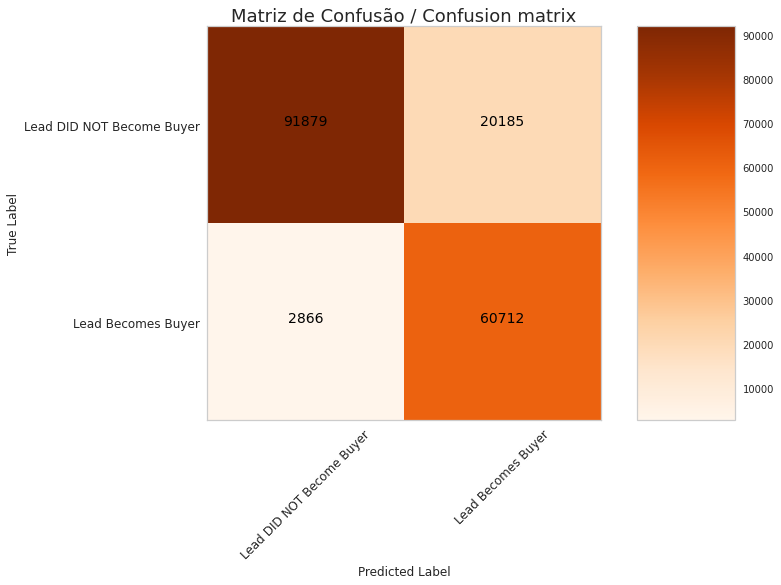

In [118]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Oranges):

    print(cm)

    # Plot the confusion matrix
    plt.figure(figsize = (12, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 18)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 12)
    plt.yticks(tick_marks, classes, size = 12)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 14,
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True Label', size = 12)
    plt.xlabel('Predicted Label', size = 12)

# Confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred_test)
plot_confusion_matrix(cm, classes = ['Lead DID NOT Become Buyer', 'Lead Becomes Buyer'], title = 'Matriz de Confusão / Confusion matrix')

In [119]:
precision, recall, threshold = precision_recall_curve(y_test, y_pred_proba_test[:, -1])

scores = pd.DataFrame({'threshold':threshold,
                       'precision': precision[:-1],
                       'recall':recall[:-1]})

scores['f1score'] = 2 * ((scores['precision'] * scores['recall']) / (scores['precision'] + scores['recall']))

In [120]:
scores

,threshold,precision,recall,f1score
0,0.000000,0.361975,1.000000,0.531544
1,0.105263,0.750040,0.965869,0.844381
2,0.153846,0.750189,0.965837,0.844463
3,0.200000,0.750266,0.965806,0.844500
4,0.222222,0.750293,0.965759,0.844499
5,0.250000,0.750306,0.965727,0.844495
6,0.333333,0.750345,0.965648,0.844490
7,0.375000,0.750434,0.964500,0.844107
8,0.400000,0.750450,0.964485,0.844111
9,0.428571,0.750459,0.964249,0.844026


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


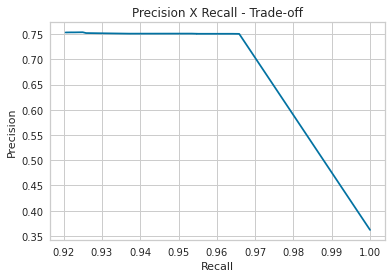

In [121]:
plt.plot(scores['recall'], scores['precision'])
plt.title('Precision X Recall - Trade-off')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

Area under ROC curve: 0.89


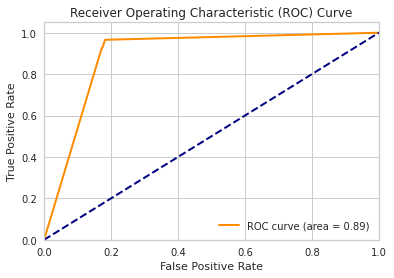

/home/solanojacon/.pyenv/versions/3.8.12/envs/4tune/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/solanojacon/.pyenv/versions/3.8.12/envs/4tune/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/solanojacon/.pyenv/versions/3.8.12/envs/4tune/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/solanojacon/.pyenv/versions/3.8.12/envs/4tune/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got

/home/solanojacon/.pyenv/versions/3.8.12/envs/4tune/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/solanojacon/.pyenv/versions/3.8.12/envs/4tune/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/solanojacon/.pyenv/versions/3.8.12/envs/4tune/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/solanojacon/.pyenv/versions/3.8.12/envs/4tune/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=libl

/home/solanojacon/.pyenv/versions/3.8.12/envs/4tune/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/solanojacon/.pyenv/versions/3.8.12/envs/4tune/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/solanojacon/.pyenv/versions/3.8.12/envs/4tune/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test pa

/home/solanojacon/.pyenv/versions/3.8.12/envs/4tune/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/solanojacon/.pyenv/versions/3.8.12/envs/4tune/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/solanojacon/.pyenv/versions/3.8.12/envs/4tune/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/solanojacon/.pyenv/versions/3.8.12/envs/4tune/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got

In [122]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test[:, -1], pos_label=True)
print("Area under ROC curve: {:0.2f}".format(auc(fpr, tpr)))

fig, ax = plt.subplots()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")
plt.show()

## Resultado final com métricas de acertividade do algoritmo / *Final result with algorithm accuracy metrics*

**O modelo escolhido apresentou um F1 score de 0,84 para os dados de teste (dados não vistos pelo modelo em seu treino).**

***The chosen model presented an F1 score of 0.84 for the test data (data not seen by the model in its training).***

Análise da matriz de confusão apresentada:
- A matriz de confusão acima mostra que **o modelo identificou 60.712 dos 63.578 leads que se tornaram compradores, que corresponde a 95,4%**.
- A matriz de confusão acima mostra também que **o modelo identificou incorretamente 20.185 dos 112.064 leads que não se tornaram compradores, também chamado de falsos positivos, que corresponde a 18,0%**.

*Analysis of the presented confusion matrix:*

- *The confusion matrix above shows that **the model identified 60,712 of the 63,578 leads that became buyers, which corresponds to 95.4%**.*
- *The confusion matrix above also shows that **the model incorrectly identified 20,185 of the 112,064 leads that did not become buyers, also called false positives, which corresponds to 18.0%**.*

## Fim / *End*